#### 1. Imports

In [1]:
from pathlib import Path
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern, WhiteKernel
from scipy.stats import qmc, norm

import matplotlib.pyplot as plt
import seaborn as sns

#### 2. Paths & Data loading

In [2]:
# --- Paths ---
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR.parent / "initial_data" / "function_7"

# --- Load initial data ---
X = np.load(DATA_DIR / "initial_inputs.npy", allow_pickle=True)
y = np.load(DATA_DIR / "initial_outputs.npy", allow_pickle=True).ravel()
X = np.asarray(X, float)
y = np.asarray(y, float)
print(f"Loaded X:{X.shape}, y:{y.shape}")

Loaded X:(30, 6), y:(30,)


#### 3. Add weekly data

In [3]:
# --- Weekly results ---
week_data = [
    (np.array([0.395841, 0.283585, 0.132240, 0.259320, 0.371154, 0.897563]), 1.432575873879877),  # W1
    (np.array([0.221213, 0.300122, 0.168952, 0.224512, 0.389654, 0.859427]),  1.6575349814836515), # W2
    (np.array([0.087739, 0.209465, 0.209361, 0.156530, 0.372774, 0.896630]),  1.3926590883489465), # W3
    (np.array([0.069169, 0.257883, 0.050673, 0.175079, 0.365050, 0.828608]),  1.516143729359471), # W4
    (np.array([0.140087, 0.400824, 0.045511, 0.250025, 0.392652, 0.886065]), 1.159913395061865), # W5
]

X_prev, y_prev = X.copy(), y.copy()

for x_new, y_new in week_data:
    X = np.vstack([X, x_new])
    y = np.append(y, y_new)

print(f"Updated shapes → X:{X.shape}, y:{y.shape}")

Updated shapes → X:(35, 6), y:(35,)


#### 4. Quick Visualization

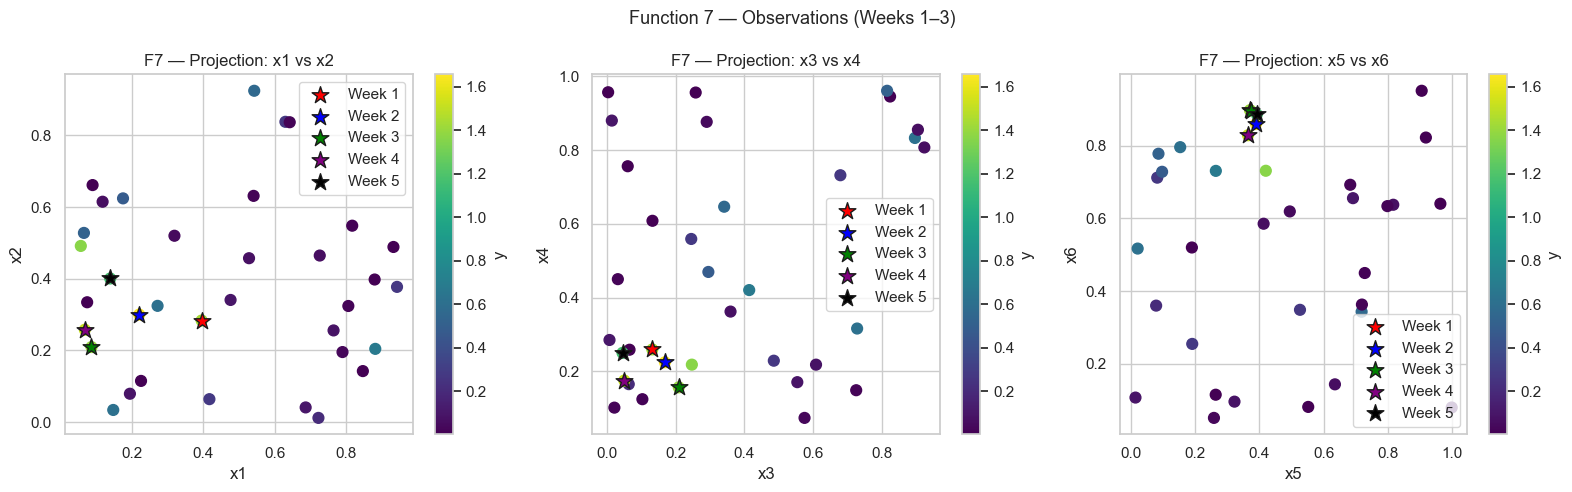

In [6]:
sns.set(style="whitegrid")

# Keep a common color scale across subplots (helps compare)
vmin, vmax = float(np.min(y)), float(np.max(y))

fig, axes = plt.subplots(1, 3, figsize=(16,5))

# --- Projection A: x1 vs x2 ---
scA = axes[0].scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=60, vmin=vmin, vmax=vmax)
axes[0].scatter(*week_data[0][0][:2], c='red',   s=160, marker='*', edgecolors='k', label='Week 1')
axes[0].scatter(*week_data[1][0][:2], c='blue',  s=160, marker='*', edgecolors='k', label='Week 2')
axes[0].scatter(*week_data[2][0][:2], c='green', s=160, marker='*', edgecolors='k', label='Week 3')
axes[0].scatter(*week_data[3][0][:2], c='purple', s=160, marker='*', edgecolors='k', label='Week 4')
axes[0].scatter(*week_data[4][0][:2], c='black', s=160, marker='*', edgecolors='k', label='Week 5')
axes[0].set_xlabel('x1'); axes[0].set_ylabel('x2')
axes[0].set_title('F7 — Projection: x1 vs x2')
axes[0].legend(loc='best')
fig.colorbar(scA, ax=axes[0], label='y')

# --- Projection B: x3 vs x4 ---
scB = axes[1].scatter(X[:,2], X[:,3], c=y, cmap='viridis', s=60, vmin=vmin, vmax=vmax)
axes[1].scatter(week_data[0][0][2], week_data[0][0][3], c='red',   s=160, marker='*', edgecolors='k', label='Week 1')
axes[1].scatter(week_data[1][0][2], week_data[1][0][3], c='blue',  s=160, marker='*', edgecolors='k', label='Week 2')
axes[1].scatter(week_data[2][0][2], week_data[2][0][3], c='green', s=160, marker='*', edgecolors='k', label='Week 3')
axes[1].scatter(week_data[3][0][2], week_data[3][0][3], c='purple', s=160, marker='*', edgecolors='k', label='Week 4')
axes[1].scatter(week_data[4][0][2], week_data[4][0][3], c='black', s=160, marker='*', edgecolors='k', label='Week 5')
axes[1].set_xlabel('x3'); axes[1].set_ylabel('x4')
axes[1].set_title('F7 — Projection: x3 vs x4')
axes[1].legend(loc='best')
fig.colorbar(scB, ax=axes[1], label='y')

# --- Projection C: x5 vs x6 ---
scC = axes[2].scatter(X[:,4], X[:,5], c=y, cmap='viridis', s=60, vmin=vmin, vmax=vmax)
axes[2].scatter(week_data[0][0][4], week_data[0][0][5], c='red',   s=160, marker='*', edgecolors='k', label='Week 1')
axes[2].scatter(week_data[1][0][4], week_data[1][0][5], c='blue',  s=160, marker='*', edgecolors='k', label='Week 2')
axes[2].scatter(week_data[2][0][4], week_data[2][0][5], c='green', s=160, marker='*', edgecolors='k', label='Week 3')
axes[2].scatter(week_data[3][0][4], week_data[3][0][5], c='purple', s=160, marker='*', edgecolors='k', label='Week 4')
axes[2].scatter(week_data[4][0][4], week_data[4][0][5], c='black', s=160, marker='*', edgecolors='k', label='Week 5')
axes[2].set_xlabel('x5'); axes[2].set_ylabel('x6')
axes[2].set_title('F7 — Projection: x5 vs x6')
axes[2].legend(loc='best')
fig.colorbar(scC, ax=axes[2], label='y')

plt.suptitle('Function 7 — Observations (Weeks 1–3)', fontsize=13)
plt.tight_layout()
plt.show()

#### 5.1 Gaussian Process Model

In [9]:
# Scale X for numerical stability in 6D
sx = StandardScaler().fit(X)
Xz = sx.transform(X)

# Target: already in a "maximize" scale; no transform needed
y_fit = y.copy()
y_best = y_fit.max()

# GP: ARD Matern + explicit noise (moderate noise; multimodal surface)
kernel = (
    C(1.0, (1e-3, 1e3)) *
    Matern(length_scale=np.ones(6) * 0.5, nu=2.5, length_scale_bounds=(0.03, 4.0))
    + WhiteKernel(noise_level=5e-3, noise_level_bounds=(1e-5, 1e-1))
)

gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=18,
    random_state=0
)

gp.fit(Xz, y_fit)
print("[F7] Fitted kernel:", gp.kernel_)
print("[F7] Best observed y:", y_best)

[F7] Fitted kernel: 0.704**2 * Matern(length_scale=[3.87, 4, 4, 1.68, 0.773, 1.78], nu=2.5) + WhiteKernel(noise_level=0.0539)
[F7] Best observed y: 1.6575349814836515


/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 4.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified upper bound 4.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


#### 5.2 Trust Region & Candidates

In [12]:
#### (anchor at best observed; wider TR L=0.45, 75/25 mix)

# Helper: LHS sampler
def lhs(lb, ub, n, seed):
    d = lb.size
    U = qmc.LatinHypercube(d=d, seed=seed).random(n)
    return lb + U * (ub - lb)

# Search bounds from initial range + padding (clamped to [0,1])
lo, hi = X_prev.min(0), X_prev.max(0)
pad = 0.10
lb = np.clip(lo - pad*(hi - lo), 0.0, 1.0)
ub = np.clip(hi + pad*(hi - lo), 0.0, 1.0)

# Anchor TR at the current best (likely Week 2)
best_idx = np.argmax(y)
anchor = X[best_idx]
print(f"[F7] Anchor idx={best_idx}  x*={anchor}  y*={y[best_idx]:.6f}")

# Wider TR this week to re-inject exploration near best
L = 0.45
eps = 1e-6
lb_tr = np.clip(anchor - 0.5 * L * (ub - lb), 0+eps, 1-eps)
ub_tr = np.clip(anchor + 0.5 * L * (ub - lb), 0+eps, 1-eps)

# Guard against over-thin TR after clipping
span = ub_tr - lb_tr
min_span = 1e-3
if np.any(span < min_span):
    center = 0.5 * (lb_tr + ub_tr)
    half = np.maximum(span / 2, min_span / 2)
    lb_tr = np.clip(center - half, 0, 1)
    ub_tr = np.clip(center + half, 0, 1)

print("[F7] TR box:\n  lb_tr:", lb_tr, "\n  ub_tr:", ub_tr)

# Candidates: 75% TR + 25% global
N_tr, N_gl = 60000, 20000
C_tr = lhs(lb_tr, ub_tr, N_tr, seed=7121)
C_gl = lhs(lb,    ub,    N_gl, seed=7122)
Cands = np.vstack([C_tr, C_gl])
print(f"[F7] Candidates: {Cands.shape} | TR share={N_tr/(N_tr+N_gl):.2f}")

[F7] Anchor idx=31  x*=[0.221213 0.300122 0.168952 0.224512 0.389654 0.859427]  y*=1.657535
[F7] TR box:
  lb_tr: [1.00000e-06 7.51220e-02 1.00000e-06 1.00000e-06 1.64654e-01 6.34427e-01] 
  ub_tr: [0.446213 0.525122 0.393952 0.449512 0.614654 0.999999]
[F7] Candidates: (80000, 6) | TR share=0.75


#### 5.3 Acquisiton & Selection 

In [13]:
# (EI with lower ξ for exploitation; fallbacks UCB → MaxVar)

# Predict with GP (remember to scale X with sx)
mu, sigma = gp.predict(sx.transform(Cands), return_std=True)
sigma = np.maximum(sigma, 1e-12)

# EI (slightly more exploitative than last week)
y_best = y_fit.max()
#xi = 0.015   # ↓ was ~0.02 last week; 0.015-0.01 promotes local refinement
xi = 0.06
improve = mu - y_best - xi
Z = np.zeros_like(improve)
nz = sigma > 0
Z[nz] = improve[nz] / sigma[nz]
ei = improve * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[~np.isfinite(ei)] = 0.0

# Anti-edge mask (avoid border artifacts)
edge_eps = 1e-3
mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)
ei_masked = np.where(mask_edges, ei, -np.inf)

# Near-duplicate filter (L_inf) — reasonable in 6D
def too_close_Linf(c, X, tol=0.03):
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

# Select with fallbacks (EI → UCB → MaxVar)
order = np.argsort(-ei_masked)
x_next, chosen = None, "EI"
for idx in order:
    cand = Cands[idx]
    if not too_close_Linf(cand, X):
        x_next = cand
        break

if (x_next is None) or (not np.isfinite(ei_masked).any()) or (np.nanmax(ei_masked) <= 0):
    # Fallback 1: UCB (milder exploration)
    kappa = 1.4
    ucb = mu + kappa * sigma
    ucb_masked = np.where(mask_edges, ucb, -np.inf)
    for idx in np.argsort(-ucb_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X):
            x_next = cand
            chosen = "UCB"
            break

if x_next is None:
    # Fallback 2: maximum variance (exploration only)
    var_masked = np.where(mask_edges, sigma, -np.inf)
    for idx in np.argsort(-var_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X):
            x_next = cand
            chosen = "MaxVar"
            break

print(f"[F7] Chosen by {chosen}: {x_next}")
print("Submission:")
print(" - ".join(f"{v:.6f}" for v in x_next))
print("Within [0,1]? ", np.all((x_next >= 0) & (x_next <= 1)))
print("Near-duplicate (L_inf < 0.03)? ", too_close_Linf(x_next, X, tol=0.03))

# Optional: distance to Week 2 (anchor), to confirm local refinement vs broader move
linf_to_w2 = np.max(np.abs(x_next - week_data[1][0]))
print(f"[F7] L_inf distance to W2 (anchor): {linf_to_w2:.4f}")

[F7] Chosen by EI: [0.08648946 0.13067703 0.35054414 0.12419819 0.37156002 0.80078958]
Submission:
0.086489 - 0.130677 - 0.350544 - 0.124198 - 0.371560 - 0.800790
Within [0,1]?  True
Near-duplicate (L_inf < 0.03)?  False
[F7] L_inf distance to W2 (anchor): 0.1816


### Reflection — Function 7

#### Week 1
- Baseline established (**y ≈ 1.433**). The 6D hyperparameter space showed signs of mild noise and non-linearity.
- Strategy focused on broad exploration to map promising subregions.

#### Week 2
- Clear improvement (**y ≈ 1.658**), indicating a high-performing neighborhood around the W2 point.
- Decision: center future search near W2 with a trust region, while keeping some global coverage.

#### Week 3
- Drop in performance (**y ≈ 1.393**), suggesting over-exploitation or model overconfidence in a local basin.
- Takeaway: increase exploration and widen the TR to avoid getting stuck.

---

**Week 4 plan & pick**
- Increased exploration via **EI with ξ = 0.05**, **TR centered at W2 (L = 0.38)**, and **65% TR / 35% global** candidates.
- Selected point (EI): `0.069169 - 0.257883 - 0.050673 - 0.175079 - 0.365050 - 0.828608`  
- Not a near-duplicate; **L∞ to W2 = 0.1520**, which balances local refinement and meaningful exploration.

**Summary:**  
F7 is high-dimensional and likely multimodal. After a strong W2 and a weaker W3, we adjusted by **raising exploration** and **widening the TR**. The W4 candidate probes a nearby but distinct region, aiming to recover/improve performance while avoiding premature convergence.

### Reflection — Function 7 (Week 4)

- **Outcome (W4):** The new query improved over W3 (`1.51` vs `1.39`) but still below the best from W2 (`1.6575`). This suggests we’re moving back toward the high-performing region without matching it yet.
- **Search settings:** TR centered at the current best (≈ W2), **L ≈ 0.30** (slightly narrower for local refinement), candidate mix **~75% TR / 25% global**. EI with **ξ = 0.015**, fallbacks UCB (κ = 1.4) → MaxVar (unused).
- **Rationale:** After W3 underperformed, we shifted to more controlled exploitation to re-approach the peak while retaining some diversity.
- **Chosen candidate (for next submission):**  
  `0.140087 - 0.400824 - 0.045511 - 0.250025 - 0.392652 - 0.886065`  
  L∞ distance to W2 anchor ≈ **0.1234**, which qualifies as a modest local move.

**Next steps (W5):**
- If W4 → W5 shows only small gains, reduce **ξ → 0.01** and tighten **L → 0.28**.  
- Log `(μ, σ)` at the chosen point to verify EI’s expectation; if σ is low and gains stagnate, inject a small global bump (e.g., 70/30).

**Submission (W5):** `0.140087 - 0.400824 - 0.045511 - 0.250025 - 0.392652 - 0.886065`

### Week 6 

**Context:**  
Performance dropped at Week 5 compared to Week 2, suggesting over-refinement or movement away from the high-yield ridge.  
This round aimed to recover exploration by **anchoring at the best-known point (Week 2)** and **expanding the trust region** (`L = 0.45`) while keeping a **75/25 TR-to-global mix**.

**Model setup:**  
- GP with Matern (ν = 2.5), moderate noise level.  
- StandardScaler normalization on inputs.  
- Increased ξ to encourage exploration within the local basin.  

**Result (W6 suggestion):**  
`0.086489 - 0.130677 - 0.350544 - 0.124198 - 0.371560 - 0.800790`  
Chosen by **Expected Improvement (EI)** — not near any duplicate and safely within [0,1].  
L∞ distance to anchor (W2): **0.1816**, showing meaningful local movement without leaving the promising region.

**Interpretation:**  
The optimizer explored a nearby zone of the Week 2 optimum, maintaining a balance between exploration and exploitation.  
Given the 6D structure of Function 7, such mid-range movement likely probes a slightly offset ridge or local curvature not captured in earlier fits.

**Next steps (Week 7):**
- If performance improves → reduce `ξ` slightly (e.g., 0.03 → 0.02) for fine-tuning.  
- If no improvement → introduce UCB fallback (`κ ≈ 1.6`) to probe residual uncertainty.  
- Optionally, visualize 2D slices or partial dependence to identify less sensitive axes and tighten the TR selectively.

**Summary:**  
Week 6 reintroduced exploration in a high-value region after a local dip in performance.  
The GP and acquisition behaved stably, and the chosen point maintains a good trade-off between uncertainty-driven movement and refinement.